In [359]:
!pip install cvxopt

Looking in indexes: https://repo.dev.wixpress.com/artifactory/api/pypi/pypi-local/simple, https://pypi.python.org/simple


In [360]:
import numpy as np
from cvxopt import printing


class Kernel(object):
    @staticmethod
    def linear():
        return lambda x, y: np.inner(x, y)
    
import numpy as np
import cvxopt.solvers
import logging


MIN_SUPPORT_VECTOR_MULTIPLIER = 1e-5


class SVMTrainer(object):
    def __init__(self, kernel, c=0.1):
        self._kernel = kernel
        self._c = c


    def train(self, X, y):
        lagrange_multipliers = self._compute_lagrange_multipliers(X, y)
        return self._create_predictor(X, y, lagrange_multipliers)


    def _kernel_matrix(self, X):
        n_samples = X.shape[0]
        K = np.zeros((n_samples, n_samples))
        for i, x_i in enumerate(X):
            for j, x_j in enumerate(X):
                K[i, j] = self._kernel(x_i, x_j)
        return K


    def _create_predictor(self, X, y, lagrange_multipliers):
        support_vector_indices = lagrange_multipliers > MIN_SUPPORT_VECTOR_MULTIPLIER
        support_multipliers = lagrange_multipliers[support_vector_indices]
        support_vectors = X[support_vector_indices]
        support_vector_labels = y[support_vector_indices]
        bias = np.mean(
            [y_k - SVMPredictor(
                    kernel=self._kernel,
                    bias=0.0,
                    weights=support_multipliers,
                    support_vectors=support_vectors,
                    support_vector_labels=support_vector_labels
                ).predict(x_k) for (y_k, x_k) in zip(support_vector_labels, support_vectors)
            ]
        )
        return SVMPredictor(
            kernel=self._kernel,
            bias=bias,
            weights=support_multipliers,
            support_vectors=support_vectors,
            support_vector_labels=support_vector_labels
        )

    def _compute_lagrange_multipliers(self, X, y):
        n_samples = X.shape[0]
        K = self._kernel_matrix(X)
        P = cvxopt.matrix(np.outer(y, y) * K)
        q = cvxopt.matrix(-1 * np.ones(n_samples))
        G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
        h = cvxopt.matrix(np.zeros(n_samples))
        A = cvxopt.matrix(y, (1, n_samples))
        b = cvxopt.matrix(0.0)
        
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        return np.ravel(solution['x'])


class SVMPredictor(object):
    def __init__(
                self,
                kernel,
                bias,
                weights,
                support_vectors,
                support_vector_labels
            ):
        
        self._kernel = kernel
        self._bias = bias
        self._weights = weights
        self._support_vectors = support_vectors
        self._support_vector_labels = support_vector_labels


        assert len(support_vectors) == len(support_vector_labels)
        assert len(weights) == len(support_vector_labels)


        logging.info("Bias: %s", self._bias)
        logging.info("Weights: %s", self._weights)
        logging.info("Support vectors: %s", self._support_vectors)
        logging.info("Support vector labels: %s", self._support_vector_labels)

    def predict(self, x):
        result = self._bias
        for w_i, x_i, y_i in zip(self._weights,
                                 self._support_vectors,
                                 self._support_vector_labels):
            result += w_i * y_i * self._kernel(x_i, x)
        #print(result)
        return np.sign(result).item()
    
    def predict_prob(self, x):
        result = self._bias
        for w_i, x_i, y_i in zip(self._weights,
                                 self._support_vectors,
                                 self._support_vector_labels):
            result += w_i * y_i * self._kernel(x_i, x)
        return result    

In [361]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import itertools

def plot(predictor, X, y, grid_size):
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, grid_size),
        np.linspace(y_min, y_max, grid_size),
        indexing='ij'
    )
    
    flatten = lambda m: np.array(m).reshape(-1,)

    result = []
    
    for (i, j) in itertools.product(range(grid_size), range(grid_size)):
        point = np.array([xx[i, j], yy[i, j]]).reshape(1, 2)
        result.append(predictor.predict(point))

    Z = np.array(result).reshape(xx.shape)
    
    plt.contourf(
        xx, yy, Z,
        cmap=cm.Paired,
        levels=[-0.01, 0.01],
        extend='both',
        alpha=0.8
    )
    
    
    plt.scatter(
        flatten(X[:, 0]),
        flatten(X[:, 1]),
        c=flatten(y),
        cmap=cm.Paired
    )
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

In [362]:
num_samples=100
num_features=2
grid_size=200
samples = np.matrix(np.random.normal(size=num_samples * num_features)
                        .reshape(num_samples, num_features))
labels = 2 * (samples.sum(axis=1) > 0) - 1.0

for i in [1, 5, 65]:
    labels[i]=labels[i]*(-1)

     pcost       dcost       gap    pres   dres
 0: -1.3518e+01 -2.8437e+01  2e+02  1e+01  2e+00
 1: -3.3575e+01 -3.7102e+01  8e+01  6e+00  9e-01
 2: -1.7288e+02 -1.6691e+02  8e+01  6e+00  9e-01
 3: -3.4574e+02 -3.2702e+02  1e+02  6e+00  9e-01
 4: -2.8863e+02 -3.1372e+02  3e+02  4e+00  7e-01
 5: -2.8340e+02 -2.8817e+02  1e+02  1e+00  2e-01
 6: -2.2285e+02 -2.2474e+02  2e+00  3e-04  4e-05
 7: -2.2355e+02 -2.2357e+02  2e-02  3e-06  4e-07
 8: -2.2356e+02 -2.2356e+02  2e-04  3e-08  4e-09
Optimal solution found.


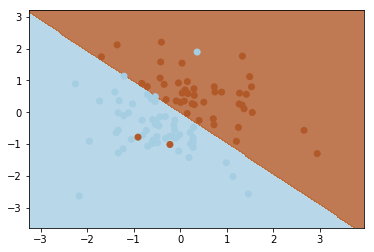

In [374]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
trainer = SVMTrainer(Kernel.linear())
X_train, X_test, y_train, y_test = train_test_split(samples, labels, test_size=.5,
                                                    random_state=2312)
predictor = trainer.train(X_train, y_train)
plot(predictor, samples, labels, grid_size)

In [365]:
def calc_cube_x(y_score):
    l = np.min(y_score)
    r = np.max(y_score)
    #a = 0.008
    #c = (l*l*l + 0.5/a - r * l * l + 0.5*l*l/(r*a*r))/(l*l/r - l)
    #b = (-0.5/a - c*l - l*l*l)/(l*l)
    b = -0.5/l
    c = 0.5/r
    #print(a*l*l*l + b*l*l + c*l)
    #print(a*r*r*r + b*r*r + c*r)
    #print(4*a*a*b*b - 12 * a*a *c)
    #print(b)
    #print(c)
    return b,c
    
def f_x(b,c,x):
    if(x<0):
        return b*x + 0.5
    else:
        return c*x + 0.5

In [366]:
y_score = [predictor.predict_prob(x) for x in X_test]
b,c = calc_cube_x(y_score)
y_score_normalized = [f_x(b,c,x) for x in y_score]
print(sorted(y_score_normalized))
#print(y_score_normalized)
#print(y_test > 0)
#print(np.array(y_score_normalized) > 0.5)

[matrix([[0.]]), matrix([[0.036]]), matrix([[0.056]]), matrix([[0.072]]), matrix([[0.076]]), matrix([[0.099]]), matrix([[0.145]]), matrix([[0.169]]), matrix([[0.183]]), matrix([[0.19]]), matrix([[0.19]]), matrix([[0.199]]), matrix([[0.222]]), matrix([[0.224]]), matrix([[0.242]]), matrix([[0.253]]), matrix([[0.257]]), matrix([[0.266]]), matrix([[0.274]]), matrix([[0.278]]), matrix([[0.278]]), matrix([[0.288]]), matrix([[0.327]]), matrix([[0.362]]), matrix([[0.398]]), matrix([[0.444]]), matrix([[0.483]]), matrix([[0.498]]), matrix([[0.499]]), matrix([[0.515]]), matrix([[0.545]]), matrix([[0.57]]), matrix([[0.572]]), matrix([[0.572]]), matrix([[0.578]]), matrix([[0.639]]), matrix([[0.655]]), matrix([[0.665]]), matrix([[0.671]]), matrix([[0.676]]), matrix([[0.685]]), matrix([[0.691]]), matrix([[0.728]]), matrix([[0.841]]), matrix([[0.849]]), matrix([[0.884]]), matrix([[0.9]]), matrix([[0.943]]), matrix([[0.988]]), matrix([[1.]])]


In [367]:
fpr = [0., 1.]
tpr = [0., 1.]
for i in range(1, 10000):
    thr = i/10000
    fp = 0
    tp = 0
    tn = 0
    fn = 0
    for j in range(len(y_score_normalized)):
        if(y_score_normalized[j]>thr):
            if(y_test[j]>0):
                tp = tp + 1
            else:
                fp = fp + 1
        else:
            if(y_test[j]>0):
                fn = fn + 1
            else:
                tn = tn + 1
    tpr.append(tp/(tp+fn))
    fpr.append(fp/(fp+tn))

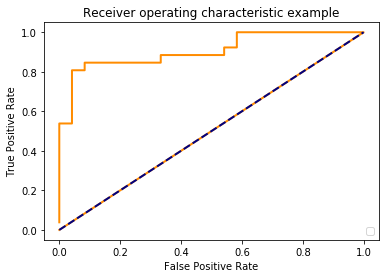

In [368]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

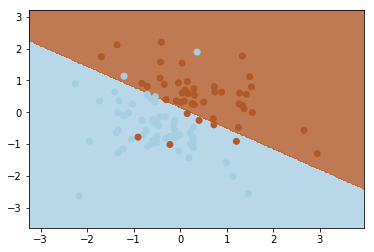

In [369]:
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True))
clf.fit(X_train, y_train)
plot(clf, samples, labels, grid_size)

In [370]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split


from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn import metrics

In [371]:
def f(x):
    if(x>0):
        return 1
    else:
        return 0

In [372]:
probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr = []
tpr = []
for i in range(0, 10001):
    thr = i/10000
    fp = 0
    tp = 0
    tn = 0
    fn = 0
    for j in range(len(preds)):
        if(preds[j]>thr):
            if(y_test[j]>0):
                tp = tp + 1
            else:
                fp = fp + 1
        else:
            if(y_test[j]>0):
                fn = fn + 1
            else:
                tn = tn + 1
    tpr.append(tp/(tp+fn))
    fpr.append(fp/(fp+tn))

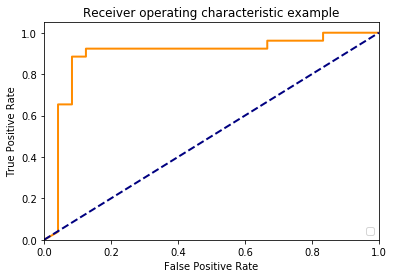

In [373]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()